In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [59]:
import numpy as np
import os
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.decomposition
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import scipy
import seaborn as sns
from cycler import cycler

plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams["axes.prop_cycle"] = cycler('color', sns.color_palette("muted")) # chooses a nicer default set of colors.
plt.rcParams['text.usetex'] = False
sns.set_context("poster")

In [3]:
def get_data_set(target_directory, target_filename, verbose = True):
    X_data = np.genfromtxt(os.path.join(target_directory, target_filename+"_trainX.csv"), delimiter=',')
    Y_data = np.genfromtxt(os.path.join(target_directory, target_filename+"_trainY.csv"), delimiter=',')
    
    if verbose:
        print('Succesfully imported dataset with of size {0}'.format(X_data.shape))
    
    return (X_data, Y_data)

In [4]:
(X_data, Y_data) = get_data_set(target_directory = './resources/run_2', target_filename = 'full')
(X_data2, Y_data2) = get_data_set(target_directory = './resources/run_1', target_filename = 'small')
(X_data3, Y_data3) = get_data_set(target_directory = './resources/run_3', target_filename = 'small')

Succesfully imported dataset with of size (1943053, 20)
Succesfully imported dataset with of size (194614, 20)
Succesfully imported dataset with of size (187030, 20)


In [60]:
def evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "",
):
    
    """
    Compares the predicted output against the training output via a violin plot.
    
    :param Y_data Output from training set.
    :param Y_predicted Output predicted by machine learning algorithm.
    :return None
    """
    
    y_buckets = sorted(set(Y_data))
    
    d=dict()
    for b in y_buckets:
        d[b] = Y_predicted[Y_data == b]
    
    plt.rcParams['figure.figsize'] = (10, 8)
#     plt.rcParams['figure.dpi'] = 300
   
    
    fig, ax = plt.subplots()
    ax.violinplot(d.values(), positions = d.keys(), showmedians = True, showextrema = False)
    ax.set_xlabel('Control input selected by optimal controller (rad/s)')
    ax.set_ylabel('Control input selected by reactive controller (rad/s)')
    ax.set_ylim([min(y_buckets), max(y_buckets)])
    ax.set_aspect('equal')
    
    major_locator = ticker.MultipleLocator((max(y_buckets) - min(y_buckets))/(len(y_buckets) - 1.))
    ax.xaxis.set_major_locator(major_locator)
    ax.yaxis.set_major_locator(major_locator)
    
    
    fig.suptitle(
        fig_title,
    )
    
    plt.savefig('optimal_reactive.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0,
        frameon=None)
    
    plt.show()

In [61]:
def run_linear_regression(
    X_data, 
    Y_data, 
    fit_intercept = True, 
    Y_weighting_function = None,
    X_transform = (lambda x: x),
    Y_transform = (lambda x: x), 
    Y_inverse_transform = (lambda x: x),
    x_labels = np.arange(0, 20)/19.0*math.pi-math.pi/2.0,
    plot_coefs = False,
    fig_title = "",
):
    
    assert np.allclose(Y_inverse_transform(Y_transform(Y_data)), Y_data), "Composing transform and inverse transform does not return identity function."
        
    if Y_weighting_function == None:
        sample_weight = None
    else:
        sample_weight = Y_weighting_function(Y_data)
    
    Xt_data = X_transform(X_data)
    Yt_data = Y_transform(Y_data)
    
    lr = sklearn.linear_model.LinearRegression(fit_intercept = fit_intercept)
    lr.fit(Xt_data, Yt_data, sample_weight)
    
    print ("Regression weights for features = ")
    print lr.coef_
    
    print ("Intercept = ")
    print lr.intercept_
    
    print ("r-value")
    print lr.score(Xt_data, Yt_data, sample_weight)
    
    if plot_coefs:
        assert Xt_data.shape[1] == len(x_labels), "The number of features does not match the length of the labels."
        fig, ax = plt.subplots()
        ax.scatter(x_labels, lr.coef_)
        plt.xticks(
            [-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2,],
            [r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', '$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',],
        )
        """
        We're inverting the x axis here to align the plot to the sign convention for the bearing.
        Negative values for the bearing correspond to the sensors on the right of the robot.
        """        
        ax.invert_xaxis()
        ax.set_xlabel('Bearing of rangefinder sensor')
        ax.set_ylabel('Coefficient')
        
        fig.suptitle(
            fig_title,
        )
        
        plt.show()
    
    Yt_predicted = lr.predict(Xt_data)
    Y_predicted = Y_inverse_transform(Yt_predicted)

    return Y_predicted

Regression weights for features = 
[-0.03095658 -0.01949426 -0.02677003 -0.03462618 -0.04171019 -0.05536625
 -0.07269059 -0.08088806 -0.07962131 -0.03693672  0.03636901  0.08357396
  0.08290121  0.0689061   0.05494826  0.04255617  0.03428646  0.02521712
  0.0174142   0.02976362]
Intercept = 
0.06311237307
r-value
0.593026257835


<IPython.core.display.Javascript object>


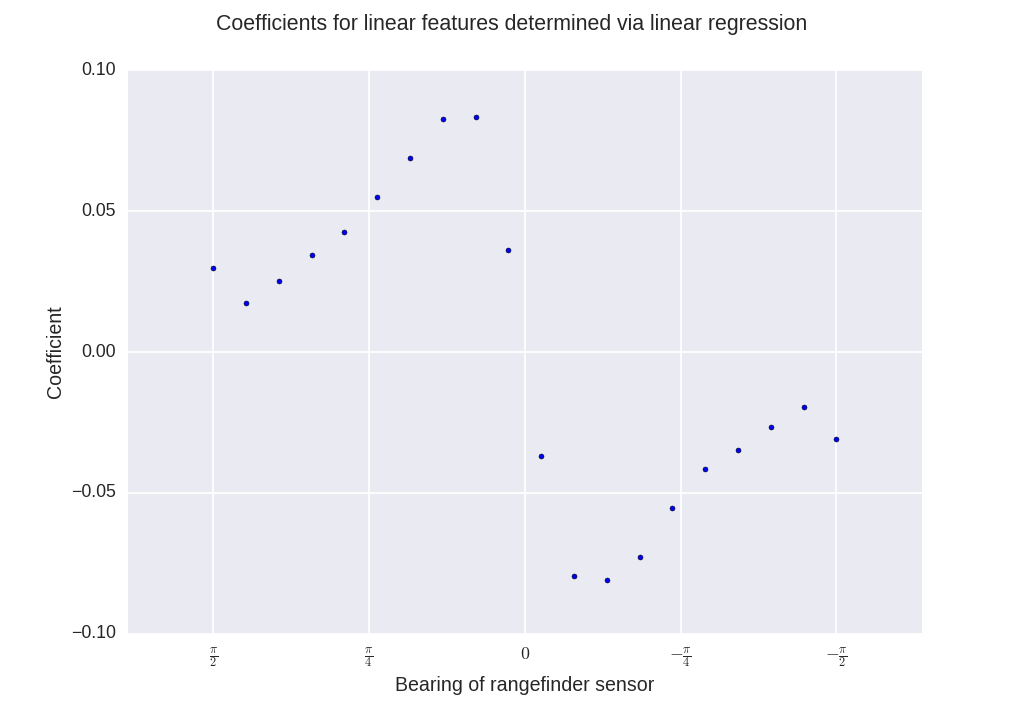

<IPython.core.display.Javascript object>


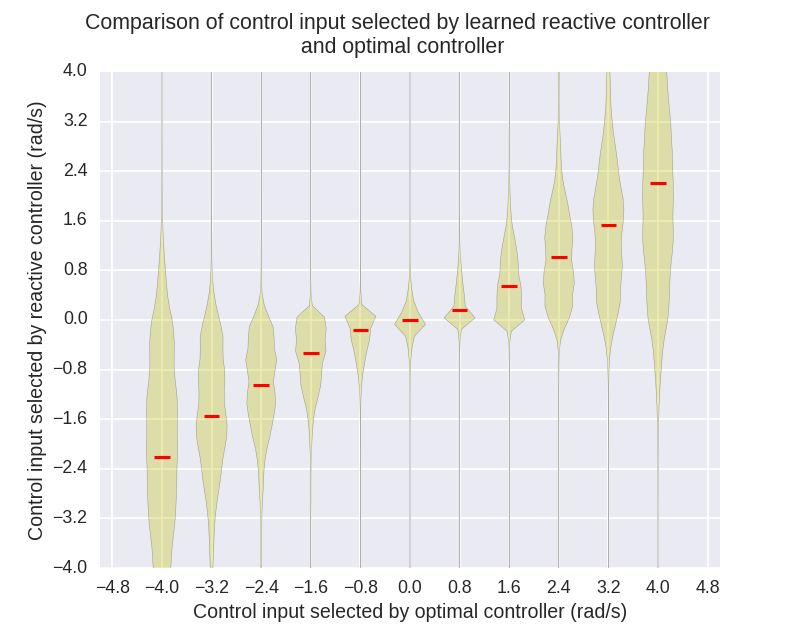

In [62]:
# linear features

Y_predicted = run_linear_regression(
    X_data, 
    Y_data, 
    Y_weighting_function = lambda Y_data: np.abs(Y_data)**6,
    plot_coefs = True,
    fig_title = "Coefficients for linear features determined via linear regression",
)
evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of control input selected by learned reactive controller \n and optimal controller",
)

In [ ]:
# cubed objective, no centering of features

Y_predicted = run_linear_regression(
    X_data, 
    Y_data, 
    Y_transform = lambda y: np.power(y, 3),
    Y_inverse_transform = lambda y: scipy.special.cbrt(y),
    plot_coefs = True,

    fig_title = "Coefficients for linear features with cubed goal determined via linear regression",
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of learned reactive controller \n to optimal controller"
)

Regression weights for features = 
[-0.12933211 -0.1168573  -0.18053814 -0.29548549 -0.43497715 -0.64520728
 -0.93109957 -1.14716128 -1.19673222 -0.62145319  0.61387357  1.24814345
  1.16823557  0.89885198  0.64761157  0.430246    0.28741517  0.17543379
  0.10411869  0.13474329]
Intercept = 
0.0
r-value
0.507933296073


<IPython.core.display.Javascript object>


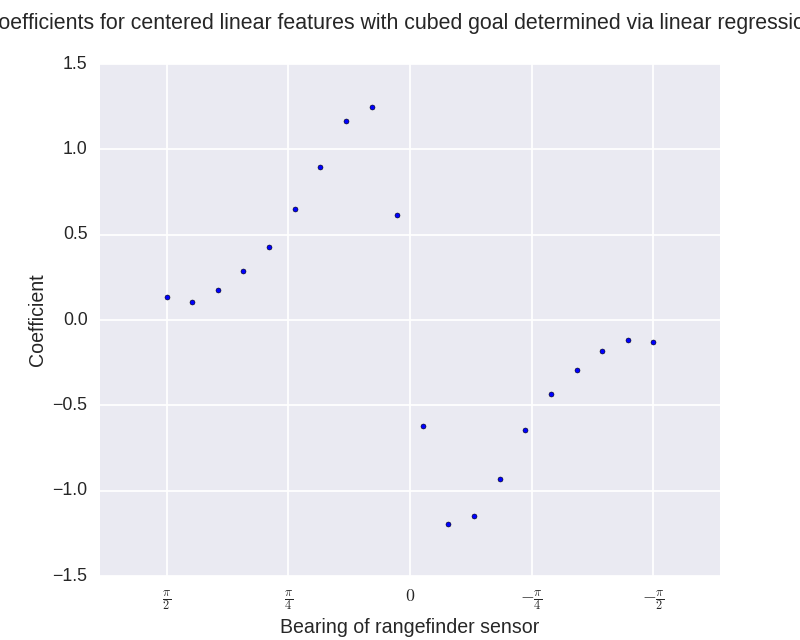

<IPython.core.display.Javascript object>


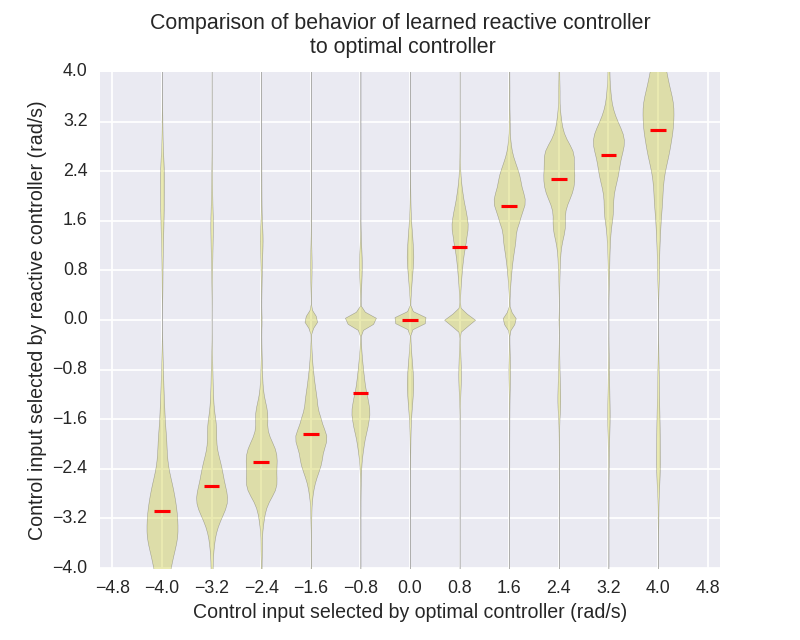

In [63]:
# cubed objective with centering of features: this forces the controller to do nothing when there are no obstacles in view.

Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    fit_intercept = False,
    X_transform = lambda x: x - np.max(x),
    Y_transform = lambda y: np.power(y, 3),
    Y_inverse_transform = lambda y: scipy.special.cbrt(y),
    plot_coefs = True,
    fig_title = "Coefficients for centered linear features with cubed goal determined via linear regression",
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of learned reactive controller\n to optimal controller"
)

In [ ]:
Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = lambda x: x**(-1.0),
    plot_coefs = True,
    fig_title = "Coefficients for inverse features determined via linear regression",
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of reactive controller to optimal controller \n using inverse features"
)

In [ ]:
# attempt at inverse controller. It's not so good.

def capped_inverse_features(X_data):
    X_features = X_data**(-1)
    cap = np.array([1])
    X_capped = np.minimum(cap, X_features)
    return X_capped

Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = capped_inverse_features,
    plot_coefs = True,
    fig_title = "Coefficients for capped inverse features determined via linear regression",
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of reactive controller to optimal controller \n using capped inverse features"
)

In [ ]:
def capped_inverse_features(X_data):
    X_features = X_data**(-1)
    cap = np.array([1])
    X_capped = np.minimum(cap, X_features)
    return X_capped

Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = capped_inverse_features,
    Y_transform = lambda y: np.power(y, 3),
    Y_inverse_transform = lambda y: scipy.special.cbrt(y),
    plot_coefs = True,
    fig_title = "Sandbox",
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Sandbox"
)

In [ ]:
# cubed features. 

Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = lambda x: x**3,
    fit_intercept = False,
    plot_coefs = True,
    fig_title = "Coefficients for cubed features determined via linear regression",
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of reactive controller to optimal controller \n using cubed features"
)

In [ ]:
Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = lambda x: sklearn.preprocessing.PolynomialFeatures(degree = 2).fit_transform(x),
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of reactive controller to optimal controller \n for linear regression, with second-degree polynomial features"
)

In [ ]:
Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = lambda x: sklearn.preprocessing.PolynomialFeatures(degree = 2).fit_transform(x),
    Y_transform = lambda y: np.power(y, 3),
    Y_inverse_transform = lambda y: scipy.special.cbrt(y),
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of reactive controller to optimal controller \n for linear regression, with second-degree polynomial features and cubed objective"
)

In [ ]:
skpca = sklearn.decomposition.PCA().fit(X_data)
skpca2 = sklearn.decomposition.PCA().fit(X_data2)
skpca3 = sklearn.decomposition.PCA().fit(X_data3)

In [ ]:
def visualize_principal_components(
    pca, 
    selected_principal_components,
    fig_title,
    x_labels = np.arange(0, 20)/19.0*math.pi-math.pi/2.0,
    n_max = None,
):
    
    # NOTE: x_labels default value is hardcoded for the specific sensor we have
    if n_max == None:
        n = len(selected_principal_components)
    else:
        n = n_max
    
    colors = sns.color_palette("husl", n)
    
    lines = []
    scatters = []
    legend_text = map(lambda x: round(x, 3), (pca.explained_variance_ratio_[i] for i in selected_principal_components))

    fig, ax = plt.subplots()
    for i in selected_principal_components:
        # TODO: I'm sure there's a better way to do this joined line plot, but I just can't figure it out yet
        line, = ax.plot(
            x_labels, 
            pca.components_[i], 
            color = colors[i],
        )
        lines.append(line)
        scatter = ax.scatter(
            x_labels, 
            pca.components_[i], 
            s = pca.explained_variance_ratio_[i]*400, 
            color = colors[i]
        )
        scatters.append(scatter)

    box = ax.get_position()
#     ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])

    ax.legend(
        scatters, 
        legend_text, 
#         bbox_to_anchor=(.0, -0.3, 1., .102), 
        loc='upper center',
        ncol=5, 
        mode="expand", 
        fontsize = 16,       
        borderaxespad=0.
    )
    
    fig.suptitle(
        fig_title,
        fontsize = 20,
    )
    
    plt.xticks(
        [-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2,],
        [r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', '$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',],
    )
    
    ax.set_ylim([-0.4, 0.4])
    
    ax.invert_xaxis()
    """
    We're inverting the x axis here to align the plot to the sign convention for the bearing.
    Negative values for the bearing correspond to the sensors on the right of the robot.
    """
    
    plt.xlabel(
        'Rangefinder bearing corresponding to basis vector',
    )
    plt.ylabel(
        'Value of eigenvector',
    )
    
    plt.show()

In [ ]:
visualize_principal_components(
    skpca, 
    range(5), 
    fig_title = "Principal component analysis on rangefinder readings \n aggregated from 10 obstacle environments",
)

In [ ]:
visualize_principal_components(
    skpca2, 
    range(5),
    fig_title = "Principal component analysis on rangefinder readings \n from single obstacle environment with 7 obstacles",
)

In [ ]:
visualize_principal_components(
    skpca3, 
    range(5),
    fig_title = "Principal component analysis on rangefinder readings \n from single obstacle environment with 20 obstacles",
)

In [ ]:
visualize_principal_components(
    skpca3, 
    range(1),
    fig_title = "Principal component analysis on rangefinder readings \n from single obstacle environment with 20 obstacles",
    n_max = 5,
)

In [ ]:
production_pca = sklearn.decomposition.PCA(n_components = 10)
X_pca = production_pca.fit_transform(X_data)
X_pca.shape

In [ ]:
Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    fit_intercept = False,
    X_transform = lambda x: sklearn.preprocessing.PolynomialFeatures(degree = 2).fit_transform(
        sklearn.decomposition.PCA(n_components = 6).fit_transform(x)
    ),
#     Y_transform = lambda y: np.power(y, 3),
#     Y_inverse_transform = lambda y: scipy.special.cbrt(y),
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of reactive controller to optimal controller \n for linear regression, with second-degree polynomial principal components as features"
)

In [ ]:
Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    fit_intercept = False,
    X_transform = lambda x: sklearn.preprocessing.PolynomialFeatures(degree = 2).fit_transform(
        sklearn.decomposition.PCA(n_components = 6).fit_transform(x)
    ),
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of reactive controller to optimal controller \n for linear regression, with second-degree polynomial PCA-ed features and cubed objective"
)

In [ ]:
Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    fit_intercept = False,
    X_transform = lambda x: sklearn.preprocessing.PolynomialFeatures(degree = 3).fit_transform(
        sklearn.decomposition.PCA(n_components = 2).fit_transform(x)
    ),
    Y_transform = lambda y: np.power(y, 3),
    Y_inverse_transform = lambda y: scipy.special.cbrt(y),
)

evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of reactive controller to optimal controller \n for linear regression, with second-degree polynomial PCA-ed features and cubed objective"
)

In [ ]:
# linear features to predict |u| - sadly, it doesn't seem to work!

Y_predicted = run_linear_regression(
    X_data, 
    np.abs(Y_data),
#     fit_intercept = False,
#     X_transform = lambda x: x - np.max(x),
#     Y_transform = lambda y: np.power(y, 3),
#     Y_inverse_transform = lambda y: scipy.special.cbrt(y),
    plot_coefs = True,
    fig_title = "Coefficients for linear features determined via linear regression for magnitude of control",
)
evaluate_predictions(
    Y_data, 
    Y_predicted,
    fig_title = "Comparison of behavior of reactive controller to optimal controller \n using linear features and only magnitude of control",
)